## Importing Packages and Processed Data

In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing, metrics
import statsmodels.api as sm

In [2]:
#Importing data
processed_data = pd.read_csv('data\Processed_data.csv')
health_data = processed_data

## Modelling

#### 1. Evaluating the collinearity between variables using Correlation Plot.

In [3]:
#Drop the id column
health_data = health_data.drop('patient_id', axis=1)

#Get the list of categorical columns in data
cat_cols = list(set(health_data.columns) - set(health_data._get_numeric_data().columns))

#Creating (k-1) dummies to avoid cyclicity in data, drop_first = True condition will help us create (k-1) dummies
health_data = pd.get_dummies(health_data, columns=cat_cols, drop_first=True)

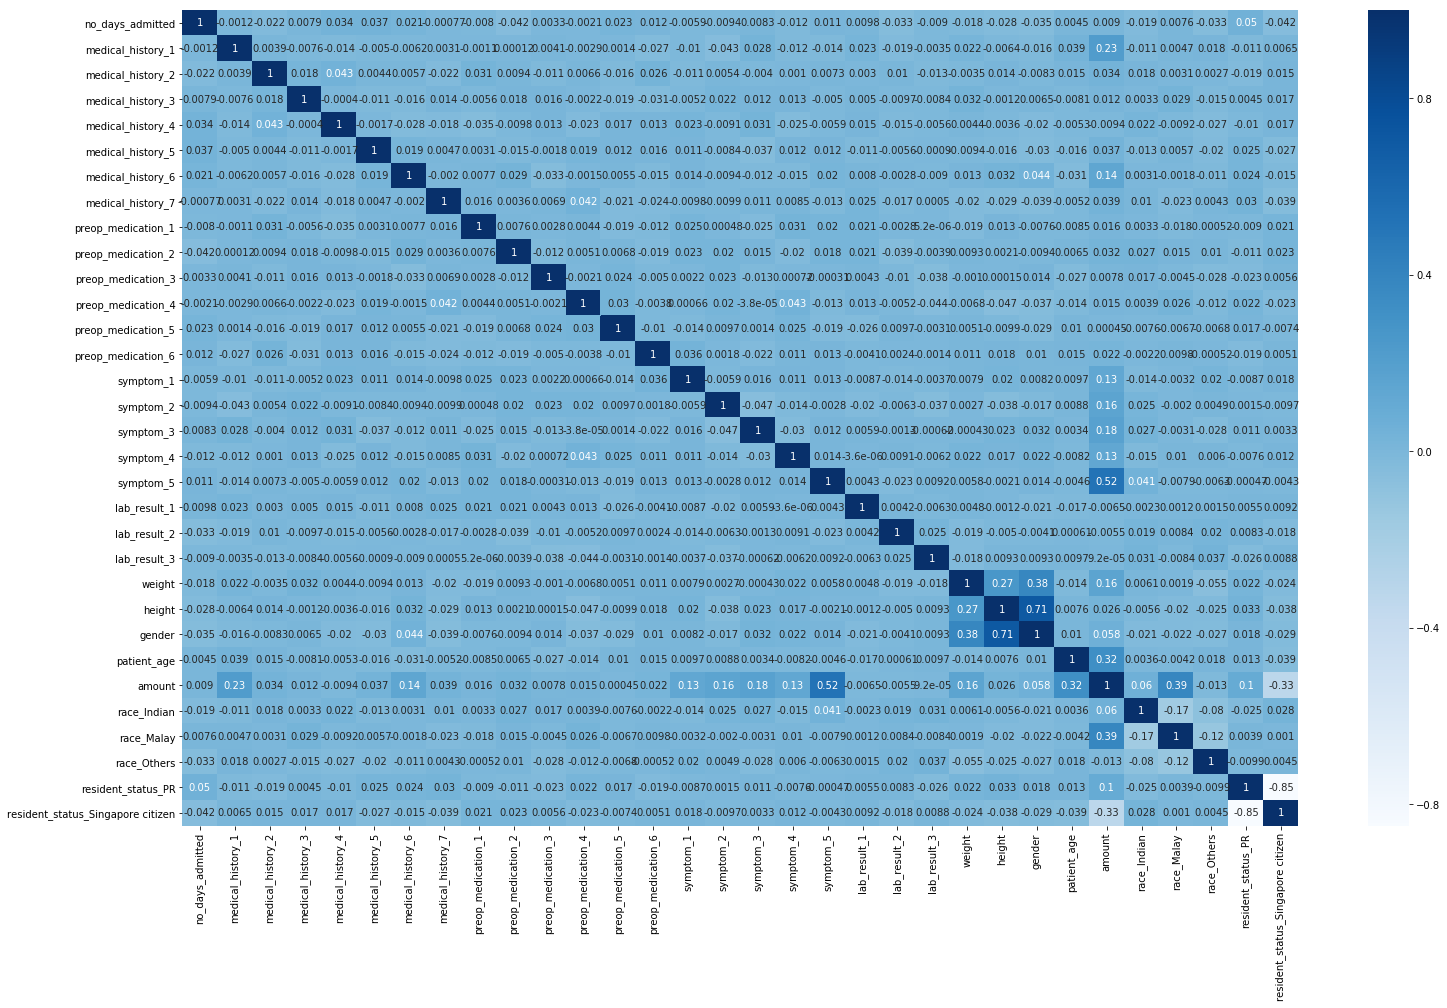

In [4]:
#Plotting the corr matrix using heatmap from seaborn package
corr = health_data.corr()
plt.subplots(figsize=(25,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Blues", annot=True)

#### 2. Building the Linear Regression Model 

In [5]:
#Drop 'gender' because of high correlation with 'height'
#Reindexing the columns
health_data = health_data[['no_days_admitted', 'medical_history_1',
       'medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_1', 'preop_medication_2', 'preop_medication_3',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height',
       'patient_age', 'race_Indian',
       'race_Malay', 'race_Others',
       'resident_status_PR', 'resident_status_Singapore citizen', 'amount']]

In [6]:
#Log transform the target variables because few records had much larger value wehn compared to 75% of the values.
health_data['amount'] = np.log(health_data['amount'])

In [7]:
#Selecting the independent and the dependent variables for Linear Regression
X1 = health_data.iloc[:,:-1]
Y1 = health_data.iloc[:,-1]

#Used StandardScaler to standardize the independent variables because they were on different scales.
scaler = preprocessing.StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X1_scaled = pd.DataFrame(X1_scaled, columns = X1.columns)

In [8]:
#Building the model
regressor = linear_model.LinearRegression()  
regressor.fit(X1_scaled, Y1)

#Making the prediction of amount
Y1_pred = regressor.predict(X1_scaled)

#Evaluating the model performance
#Finding the r-square value of  model
rsquare = regressor.score(X1_scaled,Y1)

#Calculating the root mean squared error
#Taking an exp() of Y variable because it was log transformed.
rmse = np.sqrt(metrics.mean_squared_error(np.exp(Y1),np.exp(Y1_pred)))

print("Evaluating the Model:")
print("R-Square: ", rsquare)
print("Root Mean Squared Error: ", rmse)

Evaluating the Model:
R-Square:  0.9727738521137417
Root Mean Squared Error:  1653.0659661527611


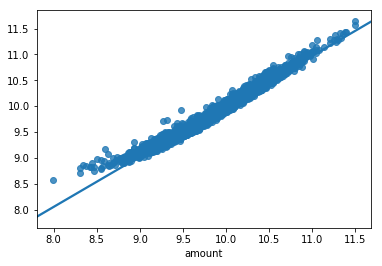

In [9]:
#Plotting the Residuals
sns.regplot(Y1, Y1_pred)

In [10]:
#Print the coefficient of independent variable
coefficients = pd.DataFrame(regressor.coef_, X1.columns, columns=['Coefficient']) 
#The target was leg transformed, so we would interpret the coefficients in terms of %change
coefficients['%Change in Cost of Care'] = (np.exp(coefficients['Coefficient']) - 1) * 100
coefficients.sort_values(by='Coefficient', ascending = False)

,Coefficient,%Change in Cost of Care
symptom_5,0.254471,28.977978
race_Malay,0.179620,19.676303
patient_age,0.142830,15.353345
medical_history_1,0.103231,10.874730
symptom_3,0.100271,10.547056
symptom_2,0.088405,9.243035
symptom_4,0.077408,8.048332
medical_history_6,0.074436,7.727672
weight,0.070100,7.261500
symptom_1,0.065503,6.769636


In [11]:
#Assuming that the key drivers are those that increase the cost of care by minimum of 10% or decrease the cost by 5% or more.
#Selecting the key driver for cost of care(amout)
coefficients = coefficients[(coefficients['%Change in Cost of Care'] >= 10) |
                            (coefficients['%Change in Cost of Care'] <= -5)].sort_values(by='Coefficient', ascending=False)
coefficients

,Coefficient,%Change in Cost of Care
symptom_5,0.254471,28.977978
race_Malay,0.179620,19.676303
patient_age,0.142830,15.353345
medical_history_1,0.103231,10.874730
symptom_3,0.100271,10.547056
resident_status_PR,-0.183141,-16.734959
resident_status_Singapore citizen,-0.277041,-24.197652


In [12]:
#Statistical information of patient_age column to find the value of one standard deviation
health_data['patient_age'].describe()

count    3400.000000
mean       58.437941
std        14.621667
min        28.000000
25%        46.000000
50%        57.000000
75%        71.000000
max        89.000000
Name: patient_age, dtype: float64

## Visualizing the Key Drivers against Cost of Care (Amount)

[Text(0,0.5,'Cost of Care (Amount)'), Text(0.5,0,'Symptom 3')]

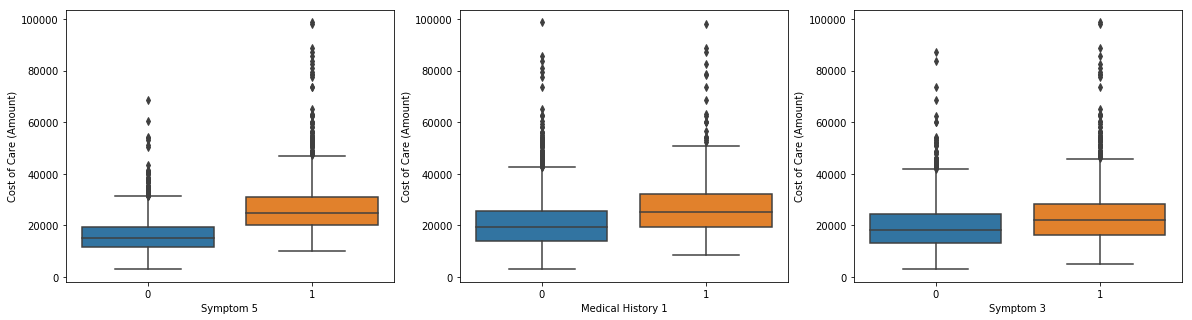

In [13]:
#Visualize the impact of clinical conditions on cost of care
f, axes = plt.subplots(1, 3,figsize=(20,5))
ax1 = sns.boxplot(data = processed_data, x='symptom_5', y='amount', ax=axes[0])
ax1.set(xlabel='Symptom 5', ylabel='Cost of Care (Amount)')
ax2 = sns.boxplot(data = processed_data, x='medical_history_1', y='amount', ax=axes[1])
ax2.set(xlabel='Medical History 1', ylabel='Cost of Care (Amount)')
ax3 = sns.boxplot(data = processed_data, x='symptom_3', y='amount', ax=axes[2])
ax3.set(xlabel='Symptom 3', ylabel='Cost of Care (Amount)')

<function matplotlib.pyplot.show(*args, **kw)>

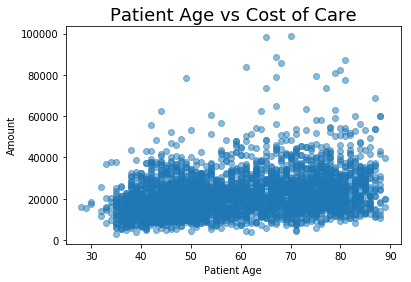

In [14]:
#Visualize the impact of patients age on the cost of care
plt.scatter(data = processed_data, x= 'patient_age', y= 'amount', alpha=0.5)
plt.title('Patient Age vs Cost of Care', size=18)
plt.xlabel('Patient Age', size=10)
plt.ylabel('Amount', size=10)
plt.show

[Text(0,0.5,'Cost of Care (Amount)'), Text(0.5,0,'Resident Status')]

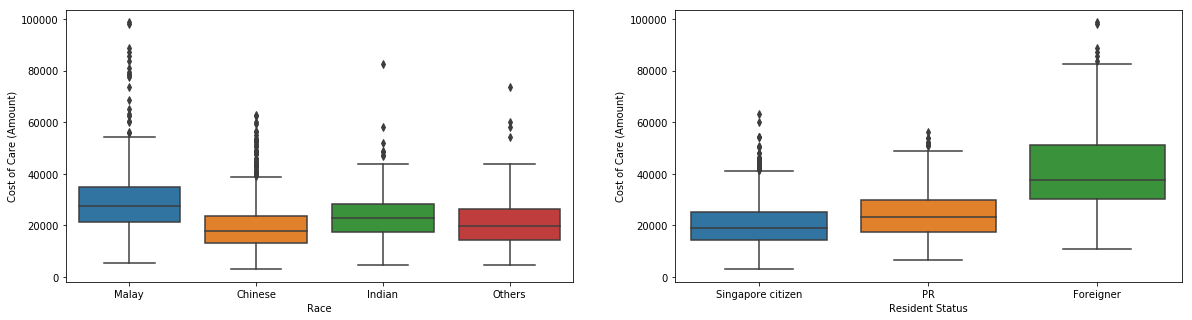

In [15]:
#Visualize the impact of race and residential status on cost of care
f, axes = plt.subplots(1, 2,figsize=(20,5))
ax4 = sns.boxplot(data = processed_data, x='race', y='amount', ax=axes[0])
ax4.set(xlabel='Race', ylabel='Cost of Care (Amount)')
ax5 = sns.boxplot(data = processed_data, x='resident_status', y='amount', ax=axes[1])
ax5.set(xlabel='Resident Status', ylabel='Cost of Care (Amount)')